<a href="https://colab.research.google.com/github/jbenasuli/final_project/blob/livia-branch/AmazonDatabase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.0'
spark_version = 'spark-3.1.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graph

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [3]:
#1 Selected furniture data
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Furniture_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df_furniture = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
df_furniture.show()
print((df_furniture.count(), len(df_furniture.columns)))

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   24509695|R3VR960AHLFKDV|B004HB5E0E|     488241329|Shoal Creek Compu...|       Furniture|          4|            0|          0|   N|                Y|... desk is very ...|This desk is very...| 2015-08-31|
|         US|   34731776|R16LGVMFKIUT0G|B0042TNMMS|     205864445|Dorel Home Produc...|       Furniture|          5|    

In [4]:
#2 Selected personal care applianaces
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Personal_Care_Appliances_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df_personal_care = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
print((df_personal_care.count(), len(df_personal_care.columns)))

(878094, 15)


In [5]:
#3 Selected office products
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Office_Products_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df_office = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
print((df_office.count(), len(df_office.columns)))

(3520528, 15)


In [6]:
#4 Selected apparel products
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df_apparel = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
print((df_apparel.count(), len(df_apparel.columns)))

(9426861, 15)


In [7]:
#5 Selected home products
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df_home = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get(""), sep="\t", header=True, inferSchema=True)
print((df_home.count(), len(df_home.columns)))

(15648420, 15)


In [8]:
#6 Merge databases
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

df_merge = unionAll(df_furniture, df_personal_care, df_office, df_apparel, df_home)
df_merge.show()

print((df_merge.count(), len(df_merge.columns)))

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   24509695|R3VR960AHLFKDV|B004HB5E0E|     488241329|Shoal Creek Compu...|       Furniture|          4|            0|          0|   N|                Y|... desk is very ...|This desk is very...| 2015-08-31|
|         US|   34731776|R16LGVMFKIUT0G|B0042TNMMS|     205864445|Dorel Home Produc...|       Furniture|          5|    

In [9]:
#7 Only considering verified purchases
df_merge = df_merge.filter(df_merge.verified_purchase == "Y")

In [10]:
#8 Drop the non-beneficial columns
columns_to_drop = ["marketplace","review_id","product_parent","star_rating","helpful_votes","total_votes","vine","review_headline","review_body","verified_purchase"]

df_merge = df_merge.drop(*columns_to_drop)
df_merge.show()

print((df_merge.count(), len(df_merge.columns)))

+-----------+----------+--------------------+----------------+-----------+
|customer_id|product_id|       product_title|product_category|review_date|
+-----------+----------+--------------------+----------------+-----------+
|   24509695|B004HB5E0E|Shoal Creek Compu...|       Furniture| 2015-08-31|
|   34731776|B0042TNMMS|Dorel Home Produc...|       Furniture| 2015-08-31|
|    1272331|B0030MPBZ4|Bathroom Vanity T...|       Furniture| 2015-08-31|
|   45284262|B005G02ESA|Sleep Master Ulti...|       Furniture| 2015-08-31|
|   18311821|B00AVUQQGQ|Serta Bonded Leat...|       Furniture| 2015-08-31|
|   42943632|B00CFY20GQ|Prepac Shoe Stora...|       Furniture| 2015-08-31|
|   43157304|B00FKC48QA|HomCom PU Leather...|       Furniture| 2015-08-31|
|   51918480|B00N9IAL9K|  Folding Step Stool|       Furniture| 2015-08-31|
|   14522766|B001T4XU1C|Ace Bayou Adult V...|       Furniture| 2015-08-31|
|   43054112|B002HRFLBC|4D Concepts Audio...|       Furniture| 2015-08-31|
|   26622950|B006MISZOC|Z

In [11]:
#9 Get datatypes
df_merge.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- review_date: string (nullable = true)



In [12]:
#10 Convert date from string to datetime
from pyspark.sql.types import *
df_merge = df_merge.withColumn("review_date", df_merge["review_date"].cast(DateType()))

df_merge.printSchema()
df_merge.show()

root
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- review_date: date (nullable = true)

+-----------+----------+--------------------+----------------+-----------+
|customer_id|product_id|       product_title|product_category|review_date|
+-----------+----------+--------------------+----------------+-----------+
|   24509695|B004HB5E0E|Shoal Creek Compu...|       Furniture| 2015-08-31|
|   34731776|B0042TNMMS|Dorel Home Produc...|       Furniture| 2015-08-31|
|    1272331|B0030MPBZ4|Bathroom Vanity T...|       Furniture| 2015-08-31|
|   45284262|B005G02ESA|Sleep Master Ulti...|       Furniture| 2015-08-31|
|   18311821|B00AVUQQGQ|Serta Bonded Leat...|       Furniture| 2015-08-31|
|   42943632|B00CFY20GQ|Prepac Shoe Stora...|       Furniture| 2015-08-31|
|   43157304|B00FKC48QA|HomCom PU Leather...|       Furniture| 2015-08-31|
|   51918480|B00N9IAL9K|

In [13]:
#10 Create column with year
from pyspark.sql.functions import year
from pyspark.sql.functions import to_date
 
df_merge = df_merge.withColumn("review_year",year(df_merge.review_date))
df_merge.show()

+-----------+----------+--------------------+----------------+-----------+-----------+
|customer_id|product_id|       product_title|product_category|review_date|review_year|
+-----------+----------+--------------------+----------------+-----------+-----------+
|   24509695|B004HB5E0E|Shoal Creek Compu...|       Furniture| 2015-08-31|       2015|
|   34731776|B0042TNMMS|Dorel Home Produc...|       Furniture| 2015-08-31|       2015|
|    1272331|B0030MPBZ4|Bathroom Vanity T...|       Furniture| 2015-08-31|       2015|
|   45284262|B005G02ESA|Sleep Master Ulti...|       Furniture| 2015-08-31|       2015|
|   18311821|B00AVUQQGQ|Serta Bonded Leat...|       Furniture| 2015-08-31|       2015|
|   42943632|B00CFY20GQ|Prepac Shoe Stora...|       Furniture| 2015-08-31|       2015|
|   43157304|B00FKC48QA|HomCom PU Leather...|       Furniture| 2015-08-31|       2015|
|   51918480|B00N9IAL9K|  Folding Step Stool|       Furniture| 2015-08-31|       2015|
|   14522766|B001T4XU1C|Ace Bayou Adult V..

In [14]:
#11 Create a table to count data rows per year
row_year_table = df_merge.groupby("review_year").agg({"review_year":"count"}).withColumnRenamed("count(review_year)", "year_count")
row_year_table.sort(row_year_table.review_year.desc()).show(truncate=False)

+-----------+----------+
|review_year|year_count|
+-----------+----------+
|2015       |10159789  |
|2014       |8613535   |
|2013       |4717096   |
|2012       |1616030   |
|2011       |808013    |
|2010       |442625    |
|2009       |198524    |
|2008       |103916    |
|2007       |77769     |
|2006       |20737     |
|2005       |10626     |
|2004       |5216      |
|2003       |5299      |
|2002       |3468      |
|2001       |2736      |
|2000       |1462      |
|1999       |123       |
|null       |0         |
+-----------+----------+



In [15]:
#12 Only considering 2010 data for week 1
df_merge = df_merge.filter(df_merge.review_year == "2010")
print((df_merge.count(), len(df_merge.columns)))

(442625, 6)


In [16]:
#13 Create table with customer_IDs and products bought (as  row)
# This method didn't work, there's a limit of 10,000 distinct values in pyspark

# summary_table = df_merge.groupby("customer_id").pivot("product_id").count()
# summary_table.show()

In [17]:
#14 Convert Pyspark dataframe into panda df
df_week1 = df_merge.toPandas()

In [19]:
#15 Save file in my drive
from google.colab import drive
drive.mount('drive')

df_week1.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [20]:
#16 Assume that every row represents that customer bought 1 item
df_week1["Quantity"] = 1
df_week1

,customer_id,product_id,product_title,product_category,review_date,review_year,Quantity
0,13682848,B001GRNO68,ORE International Black 4 Panel Plum Blossom S...,Furniture,2010-12-31,2010,1
1,52516035,B003QCJHMQ,"Winsome Wood Portland Umbrella Stand, Cappuccina",Furniture,2010-12-31,2010,1
2,19360779,B0012LYSG8,Tenley Occasional Table Set,Furniture,2010-12-31,2010,1
3,11362249,B000IHJF60,Tot Tutors WO697 Friends Collection Kids Book ...,Furniture,2010-12-31,2010,1
4,40561072,B001NMSD9Y,ITALMODERN Veronica Monitor Cart; Orange,Furniture,2010-12-31,2010,1
...,...,...,...,...,...,...,...
442620,14371548,B000LSUW6S,Braun Oral-B Sonic Complete Replacement Brushe...,Personal_Care_Appliances,2010-01-01,2010,1
442621,14812612,B001BYYCHQ,Walker or Wheelchair Bag,Personal_Care_Appliances,2010-01-01,2010,1
442622,13572974,B0013RQP08,Exergen temporal thermometer,Personal_Care_Appliances,2010-01-01,2010,1
442623,14395064,B001AHM29Y,Snore Stopper - Self-Adhesive Electrodes (1 pa...,Personal_Care_Appliances,2010-01-01,2010,1


In [21]:
#17 Too many products to create table
product_counts = df_week1.product_id.value_counts()
product_counts

B002GP7Z6Y    1242
B002O3W4LE     870
B0032AN4M6     780
B001VD5E3S     606
B001R4C5BK     591
              ... 
B000F5496G       1
B003TN0JCY       1
B001TM8UX2       1
B001S45SX6       1
B000F5VHQQ       1
Name: product_id, Length: 108486, dtype: int64

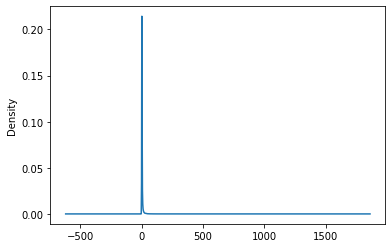

In [22]:
#18 Visualize the value counts
product_counts.plot.density()

In [ ]:
#19 Determine which values to replace
replace_product = list(product_counts[product_counts < 50].index)

# Replace in DataFrame
for product in replace_product:
    df_week1.product_id = df_week1.product_id.replace(product,"Other")

# Check to make sure binning was successful
df_week1.product_id.value_counts()

In [ ]:
#20 Drop rows of product_ids where total count is lower than 50
df_simplified = df_week1[df_week1.product_id != "Other"]
df_simplified

In [ ]:
# Consolidate the items into 1 transaction per row with each product
apriori_table = df_simplified.groupby(["customer_id","product_id"])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("customer_id")
apriori_table

In [ ]:
# Save file in my drive
from google.colab import drive
drive.mount('drive')

df_week1.to_csv('apriori_table.csv')
!cp data.csv "drive/My Drive/"